In [1]:
import pandas as pd
import numpy as np

#columns = pd.read_csv("../Chicago_Data/Chicago_Crimes_Zipcodes_Rental_Prices.csv").columns
crime_df = pd.read_csv("../Chicago_Data/Chicago_ES_Upload.csv")
crime_df['Year-Month'] = crime_df['Date'].apply(lambda x: x.split('/')[2]+'-'+x.split('/')[0])

In [ ]:
la_crime_df = pd.read_csv("../LA_Data/LA_ES_Upload.csv")
la_crime_df['Year-Month'] = crime_df['Date'].apply(lambda x: x.split('/')[2]+'-'+x.split('/')[0])
la_crime_df = la_crime_df[la_crime_df['Zipcode'].isna() == False]
la_crime_df['Zipcode'].unique()

In [3]:
def filterData(df):
    df_filter = df.loc[:, ['Zipcode', 'Year-Month', 'Rental_Price', 'Neighborhood_Score']]
    dates = df_filter['Year-Month'].unique()
    df_filter.set_index([df_filter['Zipcode'], df_filter['Year-Month']], inplace = True)
    df_filter.sort_index(inplace=True)
    df_filter.drop(columns = ['Zipcode', 'Year-Month'], inplace = True)
    df_filter = df_filter[~df_filter.index.duplicated(keep='first')]
    return df_filter


In [4]:
chi_filter = filterData(crime_df)
la_filter = filterData(la_crime_df)

In [32]:
import matplotlib.pylab as plt

def filterDF(filter_df, score_type, makePlot):
    
    plt.figure(figsize=(10,5))

    zp = filter_df.index.get_level_values('Zipcode').unique()
    df = pd.concat([filter_df.loc[zp[0],score_type], filter_df.loc[zp[1],score_type]], axis=1)
    for z in zp[2:]:
        df = pd.concat([df, filter_df.loc[z,score_type]], axis=1)
        
    df.columns = zp

    if score_type == 'Rental_Price':
        df.dropna(axis=1, how='all', inplace=True)
        df.dropna(axis = 0, how = 'all', inplace = True)
        df.fillna(method='ffill', axis = 0, inplace = True)
        df.fillna(method='bfill', axis = 0, inplace = True)
    else:
        df.fillna(0, inplace = True)
    
    df = df.transpose()
    labels = range(0,len(df.columns))
    df.columns = labels

    if makePlot:
        for i in df.index[25:30]:
            plt.plot(df.columns,df.loc[i], label = i)
            plt.xlabel('Time (Month)')
            plt.ylabel(score_type)
            plt.title(score_type + ' vs. Time')
        plt.legend()   
        plt.show()

    return df

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

import math

def predictNextMonth(df, train_months, score_type, testSet): 
    mse = 0
    y_pred = []
    y_true = []
    for zp in df.index:
        tscv = TimeSeriesSplit(n_splits=(len(df.columns)-train_months), max_train_size = train_months)
        X = np.array(df.loc[zp,:])
        X_set = []
        y_set = []
        for train_index, test_index in tscv.split(X):

            X_set.append(X[train_index])
            y_set.append(X[test_index])

        #print(X_set[-1])

        X_val = np.array(X_set[-1])
        y_val = y_set[-1]

        X_train = X_set[0:-1]
        y_train = y_set[0:-1]
    
        #X_test = df.loc[zp,(len(df.columns)-train_months):]
        #print(X_test)
        
        if testSet:
            X_test = np.array(df.loc[zp,(len(df.columns)-train_months):])
            reg = GradientBoostingRegressor(n_estimators = 500)
            reg.fit(X_train, y_train)
            y_pred.append(reg.predict(X_test.reshape(1, -1))[0])
        
        else: 
            reg = GradientBoostingRegressor(n_estimators = 500)
            reg.fit(X_train, y_train)
            y_pred.append(reg.predict(X_val.reshape(1, -1))[0])
            y_true.append(y_val)
    
    if not testSet:
        #print('Root Mean Squared Error:', math.sqrt(mean_squared_error(y_true, y_pred)))
        return math.sqrt(mean_squared_error(y_true, y_pred))
    
    df[score_type] = y_pred
    return df[score_type]


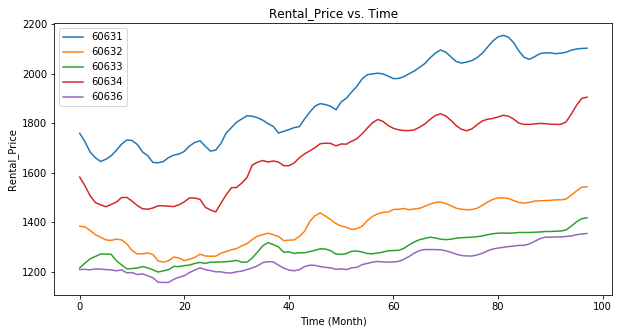

In [33]:
#chi_ns_df = filterDF(chi_filter, 'Neighborhood_Score', True)
chi_rp_df = filterDF(chi_filter, 'Rental_Price', True)
#chi_ns_pred = predictNextMonth(chi_ns_df, 6, 'Neighborhood_Score', False)
#chi_rp_pred = predictNextMonth(chi_rp_df, 6, 'Rental_Price', False)

#la_ns_df = filterDF(la_filter, 'Neighborhood_Score', False)la_rp_df = filterDF(la_filter, 'Rental_Price', False)
#la_ns_pred = predictNextMonth(la_ns_df, 6, 'Neighborhood_Score', False)
#la_rp_pred = predictNextMonth(la_rp_df, 6, 'Rental_Price', False)


#chi_combine = pd.concat([chi_ns_pred, chi_rp_pred], axis = 1)
#la_combine = pd.concat([la_ns_pred, la_rp_pred], axis = 1)
#tot_combine = pd.concat([la_combine, chi_combine], axis = 1)
#tot_combine['Year'] = '2019'
#tot_combine['Month'] = '03'

In [51]:
ns_sum = 0
rp_sum = 0
for i in range(0,100):
    ns_sum +=  predictNextMonth(la_ns_df, 6, 'Neighborhood_Score', False)
    rp_sum += predictNextMonth(la_rp_df, 6, 'Rental_Price', False)
    
print(ns_sum/1)
print(rp_sum/1)

5259.807863959048
25260.65245782761


In [2]:
25260.65245782761/100

252.60652457827612

In [446]:
chi_combine = pd.concat([chi_ns_pred, chi_rp_pred], axis = 1)
la_combine = pd.concat([la_ns_pred, la_rp_pred], axis = 1)
tot_combine = pd.concat([la_combine, chi_combine])
tot_combine['Year'] = '2019'
tot_combine['Month'] = '03'
tot_combine.to_csv('Spark_DataFrame.csv')
